In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio as rio
import seaborn as sns
import os, glob
from tifffile import imsave
import cv2
import tarfile
import pyproj as proj
from osgeo import gdal
import rasterio
import itertools
import os
import csv
from scipy.interpolate import griddata
#from arcpy import env
from rasterstats import zonal_stats
%matplotlib inline

path = os.getcwd()

In [2]:
path='E:\program'
os.chdir(path)

# extract files and make csv-files

In [17]:
#extract files to csv
import pandas
inputFolder=r'CMIP\tar_open\West_Coast'
for i in range(3,len(os.listdir(inputFolder))):
    model_name=os.listdir(inputFolder)[i]
    inputPath = os.path.join(r'CMIP\tar_open\West_Coast', model_name , 'ssp126','PrecipData')
    df = pandas.read_csv(inputPath,header=None)
    df['split'] = df[0].str.split(' ')
    amount_rows=len(df['split'])
    amount_columns=len(df['split'][0])
    list_columns=[]
    for i in range(amount_columns):
        list_columns.append(str(i))
    df2=pd.DataFrame(columns=list_columns)
    for i in range(amount_rows):
        df2.loc[i]=df['split'][i]
    outputPath = os.path.join(r'CMIP\csv_files_126', model_name + '-ssp126' +'.csv')
    df2.to_csv(outputPath, index = False)

In [18]:
#extract files to csv
import pandas
inputFolder=r'CMIP\tar_open\West_Coast'
for i in range(3,len(os.listdir(inputFolder))):
    model_name=os.listdir(inputFolder)[i]
    inputPath = os.path.join(r'CMIP\tar_open\West_Coast', model_name , 'ssp245','PrecipData')
    df = pandas.read_csv(inputPath,header=None)
    df['split'] = df[0].str.split(' ')
    amount_rows=len(df['split'])
    amount_columns=len(df['split'][0])
    list_columns=[]
    for i in range(amount_columns):
        list_columns.append(str(i))
    df2=pd.DataFrame(columns=list_columns)
    for i in range(amount_rows):
        df2.loc[i]=df['split'][i]
    outputPath = os.path.join(r'CMIP\csv_files_245', model_name + '-ssp245' +'.csv')
    df2.to_csv(outputPath, index = False)

# open csv files and select the region of interest 

In [103]:
#creates usable df from csv
def func1_usable_df(df3):
    df3=df3.fillna(0)
    df3=df3.iloc[1:]
    df3.iloc[:,0]=df3.iloc[:,0].astype(int)
    df3.iloc[:,1]=df3.iloc[:,1].astype(int)
    df3.iloc[:,2]=df3.iloc[:,2].astype(int)
    #make dates as index
    df3.iloc[:,0]=df3.iloc[:,0].astype(str)
    df3.iloc[:,1]=df3.iloc[:,1].astype(str)
    df3.iloc[:,2]=df3.iloc[:,2].astype(str)
    df3.iloc[:,0]=df3.iloc[:,0]+'-'+df3.iloc[:,1]+'-'+df3.iloc[:,2]
    df3=df3.set_index(0)
    df3 = df3.drop(columns=[1, 2]) 
    df3.iloc[0,0]=0
    df3.iloc[1,0]=0
    #remove useless columns outside mumbai extent
    df3.iloc[0]=df3.iloc[0].astype(float)
    df3.iloc[1]=df3.iloc[1].astype(float)
    df3 = df3.drop(df3.columns[df3.iloc[0] >74.05],axis=1)
    df3 = df3.drop(df3.columns[df3.iloc[1] <18.3],axis=1)
    df3 = df3.drop(df3.columns[df3.iloc[1] >20.2],axis=1) 
    for i in range(2016,2101,4):
        i=str(i)
        i=i+'-2-29'
        try:
            df3=df3.drop([i])
        except:
            pass
    return df3

In [104]:
inputFolder=r'CMIP\csv_files_126'
dictionary_126={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_126[df_name]=func1_usable_df(df) 

In [105]:
inputFolder=r'CMIP\csv_files_245'
dictionary_245={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_245[df_name]=func1_usable_df(df) 

In [106]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_370'
dictionary_370={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_370[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [107]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_585'
dictionary_585={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_585[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [108]:
#takes model average
#df4=(dictionary_585['ACCESS-CM2-ssp585']+dictionary_585['ACCESS-ESM1-5-ssp585']
#     +dictionary_585['BCC-CSM2-MR-ssp585']
#     +dictionary_585['CanESM5-ssp585']+dictionary_585['EC-Earth3-ssp585']
#     +dictionary_585['EC-Earth3-Veg-ssp585']+dictionary_585['INM-CM4-8-ssp585']
#     +dictionary_585['INM-CM5-0-ssp585']+dictionary_585['MPI-ESM1-2-HR-ssp585']
#     + dictionary_585['MPI-ESM1-2-LR-ssp585']+ dictionary_585['MRI-ESM2-0-ssp585']
#     +dictionary_585['NorESM2-LM-ssp585']+dictionary_585['NorESM2-MM-ssp585'])*(1/13)

# Rainfall overview of the models

Step1: Divide in three time frames: 2015-2040 (26 years), 2041-2070 (30 years), 2071-2100 (30 years) 
Step2: Average over space to get one single precipitation value per day
Step3: Take the top 30 precipitation values per year
Step4: make a list of all the top 30 precipitation values for a time frame
Step5: Make a histogram for the three time frames

## 126

In [109]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_126[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [110]:
#rainfall middle 30 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_126[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [111]:
#rainfall middle 30 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_126[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [112]:
d_1=func_max_begin_2('CanESM5-ssp126')
d_2=func_max_begin_3('CanESM5-ssp126')
d_3=func_max_begin_4('CanESM5-ssp126')
e_1=func_max_begin_2('EC-Earth3-ssp126')
e_2=func_max_begin_3('EC-Earth3-ssp126')
e_3=func_max_begin_4('EC-Earth3-ssp126')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp126')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp126')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp126')
g_1=func_max_begin_2('INM-CM4-8-ssp126')
g_2=func_max_begin_3('INM-CM4-8-ssp126')
g_3=func_max_begin_4('INM-CM4-8-ssp126')
h_1=func_max_begin_2('INM-CM5-0-ssp126')
h_2=func_max_begin_3('INM-CM5-0-ssp126')
h_3=func_max_begin_4('INM-CM5-0-ssp126')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp126')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp126')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp126')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp126')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp126')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp126')
k_1=func_max_begin_2('MRI-ESM2-0-ssp126')
k_2=func_max_begin_3('MRI-ESM2-0-ssp126')
k_3=func_max_begin_4('MRI-ESM2-0-ssp126')
l_1=func_max_begin_2('NorESM2-LM-ssp126')
l_2=func_max_begin_3('NorESM2-LM-ssp126')
l_3=func_max_begin_4('NorESM2-LM-ssp126')
m_1=func_max_begin_2('NorESM2-MM-ssp126')
m_2=func_max_begin_3('NorESM2-MM-ssp126')
m_3=func_max_begin_4('NorESM2-MM-ssp126')
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[d,e,f,g,h,i,j,k,l,m]

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


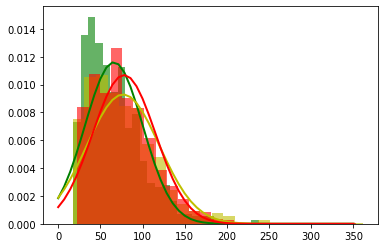

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


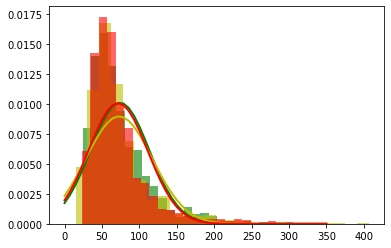

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


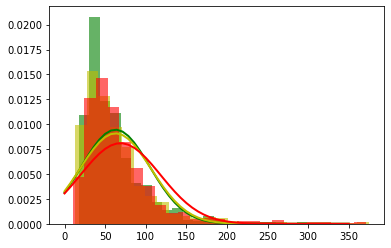

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


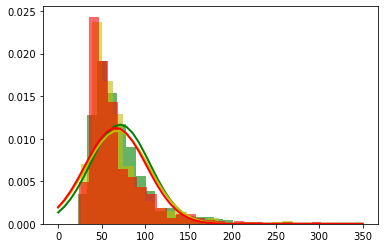

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


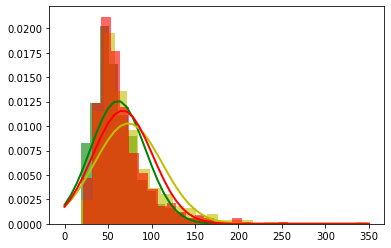

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


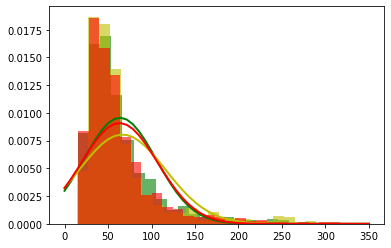

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


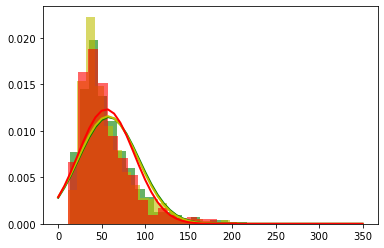

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


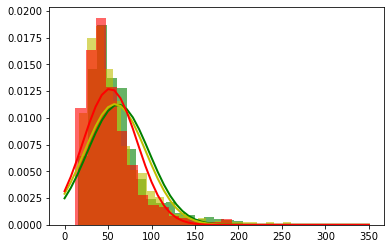

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


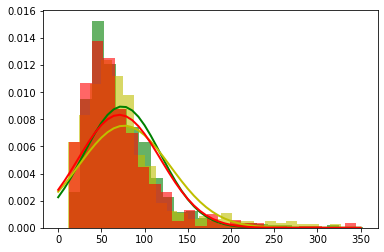

<ipython-input-113-46d14e41acc9>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-113-46d14e41acc9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-113-46d14e41acc9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


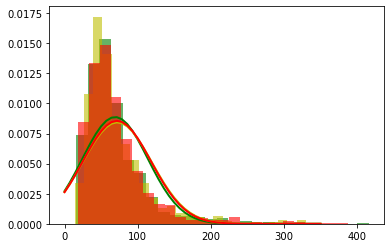

In [113]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_1=np.zeros([10,3])
std_1=np.zeros([10,3])
mu2_1=np.zeros([10,1])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_1[count]=[mu1,mu2,mu3]
    std_1[count]=[std1,std2,std3]
    mu2_1[count]=mu2
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_126_'+count2+'.png')
    plt.show()

## 245

In [114]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_245[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [115]:
#rainfall middle 30 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_245[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [116]:
#rainfall middle 30 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_245[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [117]:
d_1=func_max_begin_2('CanESM5-ssp245')
d_2=func_max_begin_3('CanESM5-ssp245')
d_3=func_max_begin_4('CanESM5-ssp245')
e_1=func_max_begin_2('EC-Earth3-ssp245')
e_2=func_max_begin_3('EC-Earth3-ssp245')
e_3=func_max_begin_4('EC-Earth3-ssp245')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp245')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp245')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp245')
g_1=func_max_begin_2('INM-CM4-8-ssp245')
g_2=func_max_begin_3('INM-CM4-8-ssp245')
g_3=func_max_begin_4('INM-CM4-8-ssp245')
h_1=func_max_begin_2('INM-CM5-0-ssp245')
h_2=func_max_begin_3('INM-CM5-0-ssp245')
h_3=func_max_begin_4('INM-CM5-0-ssp245')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp245')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp245')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp245')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp245')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp245')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp245')
k_1=func_max_begin_2('MRI-ESM2-0-ssp245')
k_2=func_max_begin_3('MRI-ESM2-0-ssp245')
k_3=func_max_begin_4('MRI-ESM2-0-ssp245')
l_1=func_max_begin_2('NorESM2-LM-ssp245')
l_2=func_max_begin_3('NorESM2-LM-ssp245')
l_3=func_max_begin_4('NorESM2-LM-ssp245')
m_1=func_max_begin_2('NorESM2-MM-ssp245')
m_2=func_max_begin_3('NorESM2-MM-ssp245')
m_3=func_max_begin_4('NorESM2-MM-ssp245')
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[d,e,f,g,h,i,j,k,l,m]

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


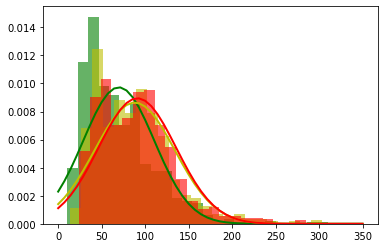

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


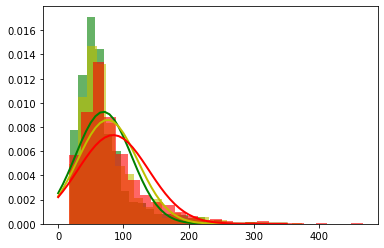

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


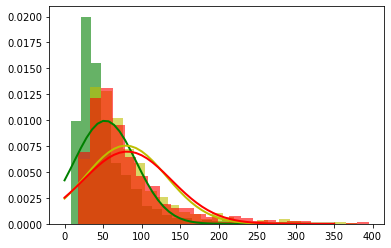

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


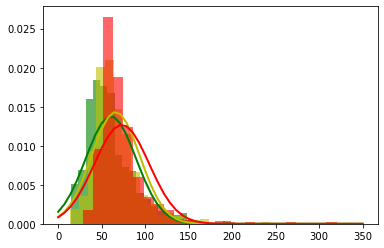

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


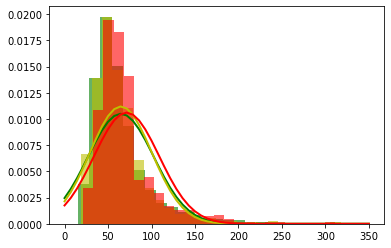

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


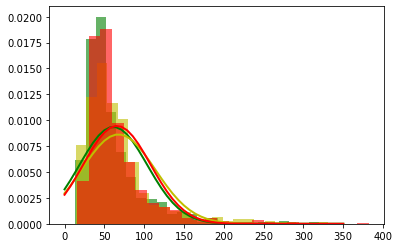

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


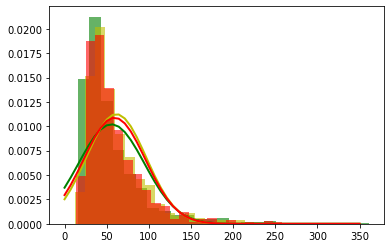

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


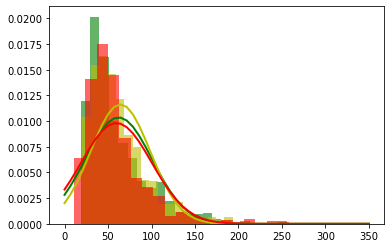

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


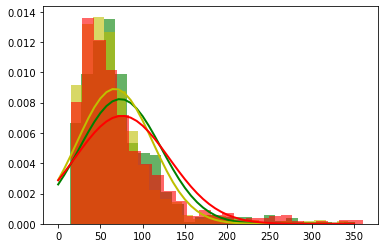

<ipython-input-118-743295bab5d4>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-118-743295bab5d4>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-118-743295bab5d4>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


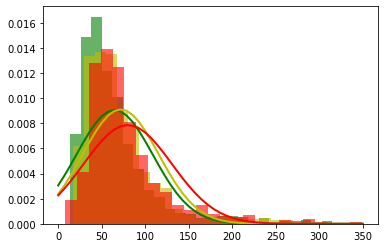

In [118]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_2=np.zeros([10,3])
std_2=np.zeros([10,3])
mu2_2=np.zeros([10,1])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_2[count]=[mu1,mu2,mu3]
    std_2[count]=[std1,std2,std3]
    mu2_2[count]=mu2
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_245_'+count2+'.png')
    plt.show()

## 370

In [119]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [120]:
#rainfall middle 30 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [121]:
#rainfall middle 30 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [122]:
a_1=func_max_begin_2('ACCESS-CM2-ssp370')
a_2=func_max_begin_3('ACCESS-CM2-ssp370')
a_3=func_max_begin_4('ACCESS-CM2-ssp370')
b_1=func_max_begin_2('ACCESS-ESM1-5-ssp370')
b_2=func_max_begin_3('ACCESS-ESM1-5-ssp370')
b_3=func_max_begin_4('ACCESS-ESM1-5-ssp370')
c_1=func_max_begin_2('BCC-CSM2-MR-ssp370')
c_2=func_max_begin_3('BCC-CSM2-MR-ssp370')
c_3=func_max_begin_4('BCC-CSM2-MR-ssp370')
d_1=func_max_begin_2('CanESM5-ssp370')
d_2=func_max_begin_3('CanESM5-ssp370')
d_3=func_max_begin_4('CanESM5-ssp370')
e_1=func_max_begin_2('EC-Earth3-ssp370')
e_2=func_max_begin_3('EC-Earth3-ssp370')
e_3=func_max_begin_4('EC-Earth3-ssp370')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp370')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp370')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp370')
g_1=func_max_begin_2('INM-CM4-8-ssp370')
g_2=func_max_begin_3('INM-CM4-8-ssp370')
g_3=func_max_begin_4('INM-CM4-8-ssp370')
h_1=func_max_begin_2('INM-CM5-0-ssp370')
h_2=func_max_begin_3('INM-CM5-0-ssp370')
h_3=func_max_begin_4('INM-CM5-0-ssp370')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp370')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp370')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp370')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp370')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp370')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp370')
k_1=func_max_begin_2('MRI-ESM2-0-ssp370')
k_2=func_max_begin_3('MRI-ESM2-0-ssp370')
k_3=func_max_begin_4('MRI-ESM2-0-ssp370')
l_1=func_max_begin_2('NorESM2-LM-ssp370')
l_2=func_max_begin_3('NorESM2-LM-ssp370')
l_3=func_max_begin_4('NorESM2-LM-ssp370')
m_1=func_max_begin_2('NorESM2-MM-ssp370')
m_2=func_max_begin_3('NorESM2-MM-ssp370')
m_3=func_max_begin_4('NorESM2-MM-ssp370')
a=[a_1,a_2,a_3]
b=[b_1,b_2,b_3]
c=[c_1,c_2,c_3]
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[a,b,c,d,e,f,g,h,i,j,k,l,m]

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


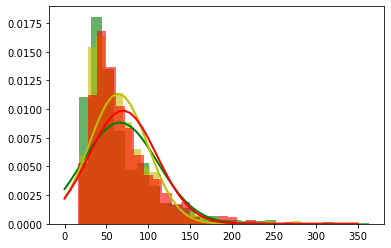

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


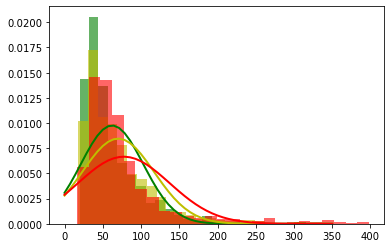

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


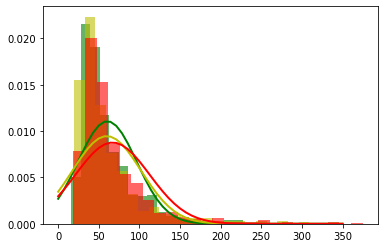

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


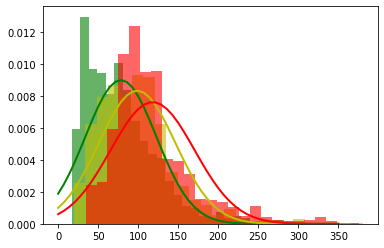

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


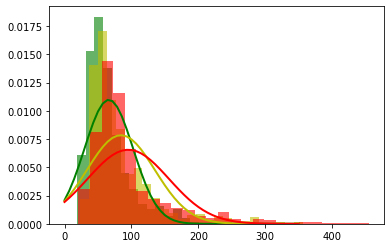

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


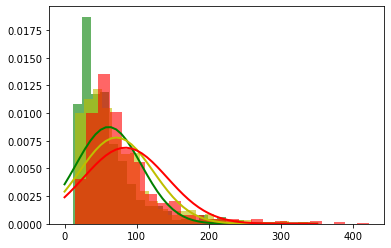

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


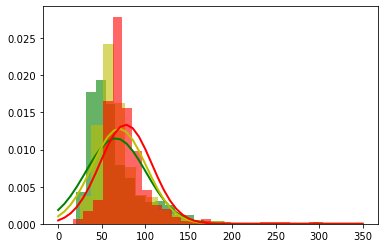

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


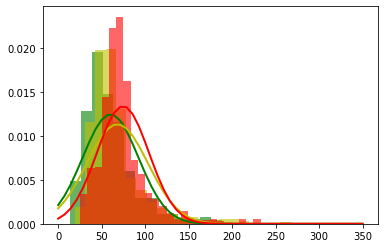

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


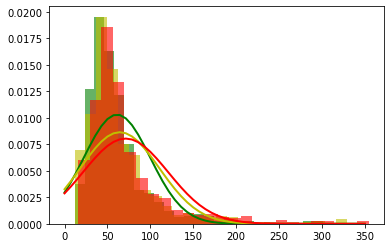

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


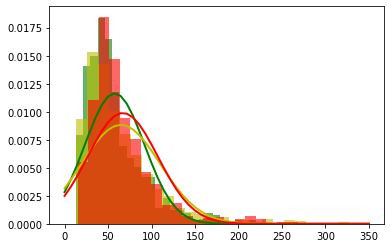

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


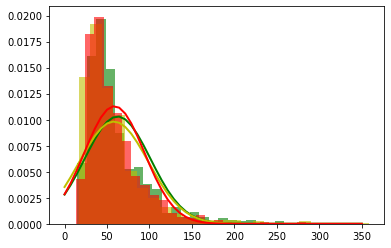

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


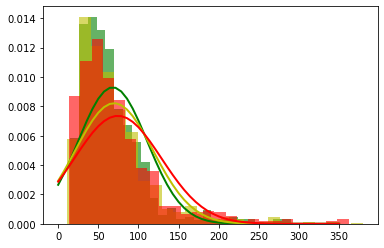

<ipython-input-124-8a79ce57daf8>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-124-8a79ce57daf8>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-124-8a79ce57daf8>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


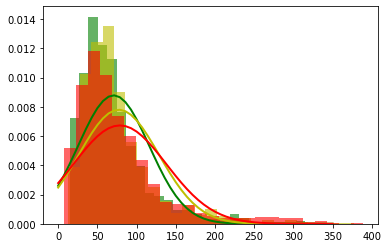

In [124]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_3=np.zeros([13,3])
std_3=np.zeros([13,3])
mu2_3=np.zeros([13,1])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_3[count]=[mu1,mu2,mu3]
    std_3[count]=[std1,std2,std3]
    mu2_3[count]=mu2
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_370_'+count2+'.png')
    plt.show()

## 585

In [125]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [126]:
#rainfall first 26 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [127]:
#rainfall first 26 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [128]:
a_1=func_max_begin_2('ACCESS-CM2-ssp585')
a_2=func_max_begin_3('ACCESS-CM2-ssp585')
a_3=func_max_begin_4('ACCESS-CM2-ssp585')
b_1=func_max_begin_2('ACCESS-ESM1-5-ssp585')
b_2=func_max_begin_3('ACCESS-ESM1-5-ssp585')
b_3=func_max_begin_4('ACCESS-ESM1-5-ssp585')
c_1=func_max_begin_2('BCC-CSM2-MR-ssp585')
c_2=func_max_begin_3('BCC-CSM2-MR-ssp585')
c_3=func_max_begin_4('BCC-CSM2-MR-ssp585')
d_1=func_max_begin_2('CanESM5-ssp585')
d_2=func_max_begin_3('CanESM5-ssp585')
d_3=func_max_begin_4('CanESM5-ssp585')
e_1=func_max_begin_2('EC-Earth3-ssp585')
e_2=func_max_begin_3('EC-Earth3-ssp585')
e_3=func_max_begin_4('EC-Earth3-ssp585')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp585')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp585')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp585')
g_1=func_max_begin_2('INM-CM4-8-ssp585')
g_2=func_max_begin_3('INM-CM4-8-ssp585')
g_3=func_max_begin_4('INM-CM4-8-ssp585')
h_1=func_max_begin_2('INM-CM5-0-ssp585')
h_2=func_max_begin_3('INM-CM5-0-ssp585')
h_3=func_max_begin_4('INM-CM5-0-ssp585')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp585')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp585')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp585')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp585')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp585')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp585')
k_1=func_max_begin_2('MRI-ESM2-0-ssp585')
k_2=func_max_begin_3('MRI-ESM2-0-ssp585')
k_3=func_max_begin_4('MRI-ESM2-0-ssp585')
l_1=func_max_begin_2('NorESM2-LM-ssp585')
l_2=func_max_begin_3('NorESM2-LM-ssp585')
l_3=func_max_begin_4('NorESM2-LM-ssp585')
m_1=func_max_begin_2('NorESM2-MM-ssp585')
m_2=func_max_begin_3('NorESM2-MM-ssp585')
m_3=func_max_begin_4('NorESM2-MM-ssp585')
a=[a_1,a_2,a_3]
b=[b_1,b_2,b_3]
c=[c_1,c_2,c_3]
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[a,b,c,d,e,f,g,h,i,j,k,l,m]

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


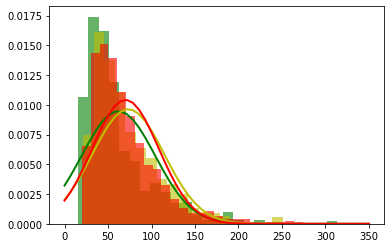

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


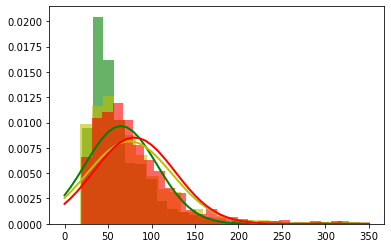

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


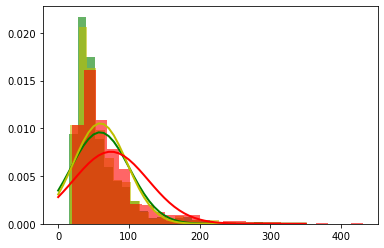

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


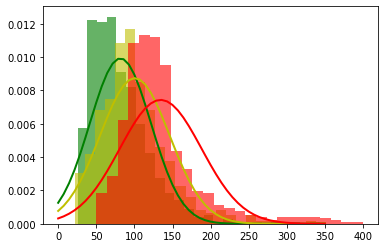

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


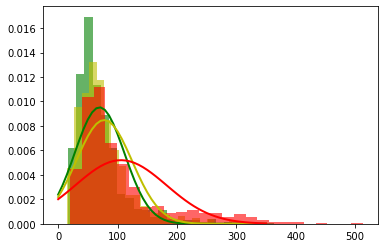

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


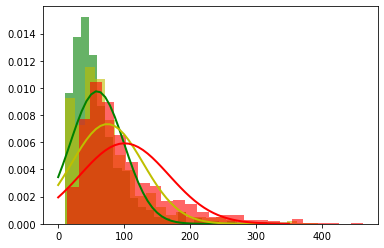

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


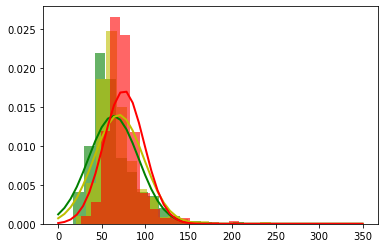

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


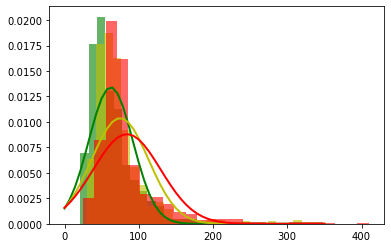

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


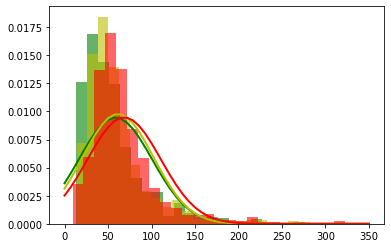

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


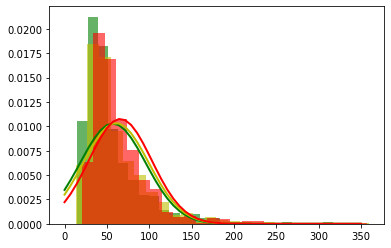

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


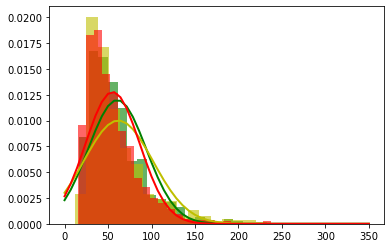

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


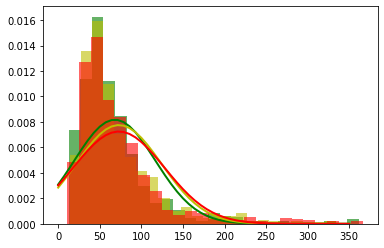

<ipython-input-129-e6f31b7f628b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-129-e6f31b7f628b>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-129-e6f31b7f628b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


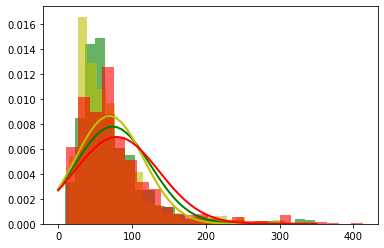

In [129]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_4=np.zeros([13,3])
std_4=np.zeros([13,3])
mu2_4=np.zeros([13,1])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_4[count]=[mu1,mu2,mu3]
    std_4[count]=[std1,std2,std3]
    mu2_4[count]=mu2
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_585_'+count2+'.png')
    plt.show()

In [130]:
mu2_1,mu2_2,mu2_3,mu2_4

(array([[76.94088502],
        [72.86198647],
        [62.77831208],
        [68.27132512],
        [73.28104106],
        [66.54688647],
        [57.43656232],
        [58.20027585],
        [76.50287633],
        [72.04966522]]),
 array([[88.02768889],
        [75.68639614],
        [79.52937633],
        [66.11943575],
        [64.79811111],
        [67.72270193],
        [61.36164155],
        [64.26268164],
        [67.11879469],
        [71.8940715 ]]),
 array([[64.15394638],
        [70.09769469],
        [59.81081546],
        [98.6455285 ],
        [84.24353913],
        [71.85627778],
        [70.17088937],
        [68.10060725],
        [64.37291836],
        [64.72787536],
        [58.06749034],
        [69.71266039],
        [77.42072271]]),
 array([[ 73.29059179],
        [ 74.58882995],
        [ 59.45994976],
        [100.58100773],
        [ 77.36671353],
        [ 74.71425942],
        [ 69.73181159],
        [ 74.79928213],
        [ 61.56315169],
        [ 60.794138

In [152]:
mu2_1_flat=[]
mu2_1_flat = [item for sublist in mu2_1 for item in sublist]
mu2_2_flat=[]
mu2_2_flat = [item for sublist in mu2_2 for item in sublist]
mu2_3_flat=[]
mu2_3_flat = [item for sublist in mu2_3 for item in sublist]
mu2_4_flat=[]
mu2_4_flat = [item for sublist in mu2_4 for item in sublist]

In [153]:
mu2_3

array([[64.15394638],
       [70.09769469],
       [59.81081546],
       [98.6455285 ],
       [84.24353913],
       [71.85627778],
       [70.17088937],
       [68.10060725],
       [64.37291836],
       [64.72787536],
       [58.06749034],
       [69.71266039],
       [77.42072271]])

In [156]:
df=pd.DataFrame(columns=['126','245','370','585'],index=['model1','model2','model3','model4','model5','model6','model7','model8','model9','model10','model11','model12','model13','mean'])
df.iloc[3:,0]=mu2_1_flat
df.iloc[3:,1]=mu2_2_flat
df.iloc[:,2]=mu2_3_flat
df.iloc[:,3]=mu2_4_flat

In [160]:
a=[np.mean(mu2_1_flat),np.mean(mu2_2_flat),np.mean(mu2_3_flat),np.mean(mu2_4_flat)]
a

[68.48698159420289, 70.65208995169081, 70.87545890003716, 71.61983333333333]

In [28]:
#370
print(mu_1)
print(mu_2)
print(mu_3[3:])
print(mu_4[3:])

[[65.98822631 76.94088502 78.07205411]
 [73.98396934 72.86198647 71.54386039]
 [62.80663489 62.77831208 68.86146135]
 [71.23542196 68.27132512 66.19265556]
 [61.35187458 73.28104106 66.85969952]
 [63.73767224 66.54688647 63.24775121]
 [58.30383668 57.43656232 55.27453333]
 [61.72179097 58.20027585 52.39988599]
 [74.0964398  76.50287633 70.79473913]
 [69.16818227 72.04966522 71.63048357]]
[[69.70056745 88.02768889 91.03508309]
 [69.35717726 75.68639614 84.33775121]
 [52.69082107 79.52937633 81.53046763]
 [60.62059532 66.11943575 73.16733237]
 [64.77410201 64.79811111 71.34454976]
 [61.30762207 67.72270193 65.76889952]
 [55.66675641 61.36164155 59.2886256 ]
 [62.14198439 64.26268164 59.68161304]
 [73.57012876 67.11879469 75.44205797]
 [64.88103177 71.8940715  80.02355556]]
[[ 78.35625697  98.6455285  117.96066039]
 [ 66.16358082  84.24353913  95.22134251]
 [ 61.08470513  71.85627778  84.25883913]
 [ 66.21109643  70.17088937  77.70833333]
 [ 60.23877982  68.10060725  74.5028314 ]
 [ 61.16

IndexError: invalid index to scalar variable.

In [113]:
sum([item[1] for item in mu_1])/10

68.48698159420289

In [114]:
sum([item[1] for item in mu_2])/10

70.65208995169083

In [115]:
sum([item[1] for item in mu_3])/13

70.87545890003717

In [116]:
sum([item[1] for item in mu_4])/13

71.61983333333333

In [102]:
#370
print(std_1)
print(std_2)
print(std_3)
print(std_4)

[[34.36317107 42.9164584  37.31012582]
 [39.3884106  44.43013605 39.5845039 ]
 [42.20877177 43.92232329 49.28048003]
 [34.19774675 36.44650269 35.33995918]
 [31.71074617 38.81241091 34.42329978]
 [41.70279039 49.57289951 43.91654758]
 [34.71519258 34.441181   32.35139165]
 [35.48536693 35.30738442 31.34284642]
 [44.61403655 53.00963034 47.91573356]
 [44.96201277 47.30428362 46.64046766]]
[[41.00787835 46.17201777 44.58821042]
 [43.05555561 46.40562999 54.36241672]
 [40.08610805 52.88533179 57.24557689]
 [28.95450172 27.85302139 31.45369371]
 [38.00212683 35.63128134 37.59287781]
 [42.63938553 46.20615713 42.18925342]
 [39.09555093 35.46618608 36.66376765]
 [38.50171769 34.29753964 40.63738344]
 [48.43069274 44.76254891 55.96380944]
 [44.02817075 43.79632704 50.72101526]]
[[45.15077403 35.18360324 40.37835667]
 [40.87586178 47.16463234 59.88493405]
 [36.05379499 42.17105747 45.50423279]
 [44.3294077  47.88031546 52.38370459]
 [36.3580313  50.89850503 60.90950444]
 [45.59742695 51.168894

In [52]:
#585
std_2

array([[42.16256403, 41.43319927, 38.31183368],
       [41.33450243, 48.94832852, 46.8267015 ],
       [41.62374158, 37.90169776, 52.84519741],
       [40.18803842, 45.64784475, 53.66320211],
       [41.88169889, 47.00535963, 76.68283996],
       [40.88419545, 54.34853357, 67.36249036],
       [28.83675513, 28.53690843, 23.34684613],
       [29.75212109, 38.44594095, 45.35032115],
       [42.20993714, 40.81828002, 42.11296875],
       [38.76996087, 38.59640043, 37.06872047],
       [33.27082838, 39.87920487, 31.23164271],
       [48.81222763, 51.45116476, 55.0403265 ],
       [51.17095467, 46.12095617, 57.31049489]])

# Try 2

# Step1: make a raster for each day in the dataframe and export it

In [32]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_585'
dictionary_585={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_585[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [33]:
df1_1=dictionary_585['ACCESS-CM2-ssp585'][0:2]
df1_2=dictionary_585['ACCESS-CM2-ssp585'][7302:18252]
df1=pd.concat([df1_1,df1_2])
df2_1=dictionary_585['ACCESS-ESM1-5-ssp585'][0:2]
df2_2=dictionary_585['ACCESS-ESM1-5-ssp585'][7302:18252]
df2=pd.concat([df2_1,df2_2])
df3_1=dictionary_585['BCC-CSM2-MR-ssp585'][0:2]
df3_2=dictionary_585['BCC-CSM2-MR-ssp585'][7302:18252]
df3=pd.concat([df3_1,df3_2])
df4_1=dictionary_585['CanESM5-ssp585'][0:2]
df4_2=dictionary_585['CanESM5-ssp585'][7302:18252]
df4=pd.concat([df4_1,df4_2])

In [6]:
df5_1=dictionary_585['EC-Earth3-ssp585'][0:2]
df5_2=dictionary_585['EC-Earth3-ssp585'][7302:18252]
df5=pd.concat([df5_1,df5_2])
df6_1=dictionary_585['EC-Earth3-Veg-ssp585'][0:2]
df6_2=dictionary_585['EC-Earth3-Veg-ssp585'][7302:18252]
df6=pd.concat([df6_1,df6_2])
df7_1=dictionary_585['INM-CM4-8-ssp585'][0:2]
df7_2=dictionary_585['INM-CM4-8-ssp585'][7302:18252]
df7=pd.concat([df7_1,df7_2])
df8_1=dictionary_585['INM-CM5-0-ssp585'][0:2]
df8_2=dictionary_585['INM-CM5-0-ssp585'][7302:18252]
df8=pd.concat([df8_1,df8_2])
df9_1=dictionary_585['MPI-ESM1-2-HR-ssp585'][0:2]
df9_2=dictionary_585['MPI-ESM1-2-HR-ssp585'][7302:18252]
df9=pd.concat([df9_1,df9_2])
df10_1=dictionary_585['MPI-ESM1-2-LR-ssp585'][0:2]
df10_2=dictionary_585['MPI-ESM1-2-LR-ssp585'][7302:18252]
df10=pd.concat([df10_1,df10_2])
df11_1=dictionary_585['MRI-ESM2-0-ssp585'][0:2]
df11_2=dictionary_585['MRI-ESM2-0-ssp585'][7302:18252]
df11=pd.concat([df11_1,df11_2])
df12_1=dictionary_585['NorESM2-LM-ssp585'][0:2]
df12_2=dictionary_585['NorESM2-LM-ssp585'][7302:18252]
df12=pd.concat([df12_1,df12_2])
df13_1=dictionary_585['NorESM2-MM-ssp585'][0:2]
df13_2=dictionary_585['NorESM2-MM-ssp585'][7302:18252]
df13=pd.concat([df13_1,df13_2])

In [117]:
df1_1=dictionary_370['ACCESS-CM2-ssp370'][0:2]
df1_2=dictionary_370['ACCESS-CM2-ssp370'][7302:18252]
df1=pd.concat([df1_1,df1_2])
df2_1=dictionary_370['ACCESS-ESM1-5-ssp370'][0:2]
df2_2=dictionary_370['ACCESS-ESM1-5-ssp370'][7302:18252]
df2=pd.concat([df2_1,df2_2])
df3_1=dictionary_370['BCC-CSM2-MR-ssp370'][0:2]
df3_2=dictionary_370['BCC-CSM2-MR-ssp370'][7302:18252]
df3=pd.concat([df3_1,df3_2])
df4_1=dictionary_370['CanESM5-ssp370'][0:2]
df4_2=dictionary_370['CanESM5-ssp370'][7302:18252]
df4=pd.concat([df4_1,df4_2])
df5_1=dictionary_370['EC-Earth3-ssp370'][0:2]
df5_2=dictionary_370['EC-Earth3-ssp370'][7302:18252]
df5=pd.concat([df5_1,df5_2])
df6_1=dictionary_370['EC-Earth3-Veg-ssp370'][0:2]
df6_2=dictionary_370['EC-Earth3-Veg-ssp370'][7302:18252]
df6=pd.concat([df6_1,df6_2])
df7_1=dictionary_370['INM-CM4-8-ssp370'][0:2]
df7_2=dictionary_370['INM-CM4-8-ssp370'][7302:18252]
df7=pd.concat([df7_1,df7_2])
df8_1=dictionary_370['INM-CM5-0-ssp370'][0:2]
df8_2=dictionary_370['INM-CM5-0-ssp370'][7302:18252]
df8=pd.concat([df8_1,df8_2])
df9_1=dictionary_370['MPI-ESM1-2-HR-ssp370'][0:2]
df9_2=dictionary_370['MPI-ESM1-2-HR-ssp370'][7302:18252]
df9=pd.concat([df9_1,df9_2])
df10_1=dictionary_370['MPI-ESM1-2-LR-ssp370'][0:2]
df10_2=dictionary_370['MPI-ESM1-2-LR-ssp370'][7302:18252]
df10=pd.concat([df10_1,df10_2])
df11_1=dictionary_370['MRI-ESM2-0-ssp370'][0:2]
df11_2=dictionary_370['MRI-ESM2-0-ssp370'][7302:18252]
df11=pd.concat([df11_1,df11_2])
df12_1=dictionary_370['NorESM2-LM-ssp370'][0:2]
df12_2=dictionary_370['NorESM2-LM-ssp370'][7302:18252]
df12=pd.concat([df12_1,df12_2])
df13_1=dictionary_370['NorESM2-MM-ssp370'][0:2]
df13_2=dictionary_370['NorESM2-MM-ssp370'][7302:18252]
df13=pd.concat([df13_1,df13_2])

In [118]:
def func_make_raster(df,folder_name):
    #generate a list of coordinates present in the dataframe 
    isExist = os.path.exists(folder_name)
    if not isExist:
        os.mkdir(folder_name)
    longitudes=df.iloc[0]
    lattitudes=df.iloc[1]
    coordinates=np.vstack((longitudes, lattitudes)).T
    # make the framework for a raster
    rRes=0.25
    min_x=df.iloc[0].min()
    max_x=df.iloc[0].max()
    min_y=df.iloc[1].min()
    max_y=df.iloc[1].max()
    xrange=np.arange(min_x,max_x+rRes,rRes)
    yrange=np.arange(min_y,max_y+rRes,rRes)
    yrange_2=np.flip(yrange)
    gridX,gridY = np.meshgrid(xrange, yrange_2)
    #problem: we have raster with unprojected coordinates, hence we need to define the average width and height resolution and begin point(topleft) to export the raster
    #coordinates top left:
    longitude_top_left=df.iloc[0].min()-0.125
    lattitude_top_left=df.iloc[1].max()+0.125
    crs_wgs = proj.Proj('EPSG:4326') #were using WGS84 geographic
    crs_bng = proj.Proj('EPSG:32643')
    topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
    #average resolution:
    longitude_top_right=df.iloc[0].max()+0.125
    lattitude_top_right=df.iloc[1].max()+0.125
    topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
    res_width=(topright_x-topleft_x)/4
    longitude_bottom_left=df.iloc[0].min()-0.125
    lattitude_bottom_left=df.iloc[1].min()-0.125
    bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
    res_height=(topleft_y-bottomleft_y)/8
    #set-up projection variables
    path_projection = r'MMR_Area_and_SubBasins\mmr_boundary_raster_final.tif'
    open_projection=gdal.Open(path_projection)
    projection = open_projection.GetProjection()
    geotrans=(topleft_x, res_width,0.0,topleft_y,0.0,-res_height) 
    #fill in values into raster and export it
    for i in range(2,len(df)):
        values=list(df.iloc[i])
        grid = griddata(coordinates, values, (gridX,gridY), method='nearest')
        outputPath = os.path.join(folder_name,df.iloc[i].name +'.tif')
        cv2.imwrite(outputPath, grid)
        dataset2 = gdal.Open(outputPath, gdal.GA_Update)
        dataset2.SetGeoTransform(geotrans)
        dataset2.SetProjection(projection)

In [35]:
func_make_raster(df1,r'CMIP\585\model_1_585_rasters')
func_make_raster(df2,r'CMIP\585\model_2_585_rasters')
func_make_raster(df3,r'CMIP\585\model_3_585_rasters')
func_make_raster(df4,r'CMIP\585\model_4_585_rasters')

<ipython-input-34-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-34-a55a27e2af5f>:29: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-34-a55a27e2af5f>:33: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
<ipython-input-34-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyp

In [8]:
#func_make_raster(df1,r'CMIP\585\model_1_585_rasters')
#func_make_raster(df2,r'CMIP\585\model_2_585_rasters')
#func_make_raster(df3,r'CMIP\585\model_3_585_rasters')
#func_make_raster(df4,r'CMIP\585\model_4_585_rasters')
#func_make_raster(df5,r'CMIP\585\model_5_585_rasters')
#func_make_raster(df6,r'CMIP\585\model_6_585_rasters')
func_make_raster(df7,r'CMIP\585\model_7_585_rasters')
func_make_raster(df8,r'CMIP\585\model_8_585_rasters')
func_make_raster(df9,r'CMIP\585\model_9_585_rasters')
func_make_raster(df10,r'CMIP\585\model_10_585_rasters')
func_make_raster(df11,r'CMIP\585\model_11_585_rasters')
func_make_raster(df12,r'CMIP\585\model_12_585_rasters')
func_make_raster(df13,r'CMIP\585\model_13_585_rasters')

<ipython-input-7-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-7-a55a27e2af5f>:29: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-7-a55a27e2af5f>:33: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
<ipython-input-7-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

In [7]:
func_make_raster(df1,r'CMIP\585\model_1_585_rasters')
func_make_raster(df2,r'CMIP\585\model_2_585_rasters')
func_make_raster(df3,r'CMIP\585\model_3_585_rasters')
func_make_raster(df4,r'CMIP\585\model_4_585_rasters')
func_make_raster(df5,r'CMIP\585\model_5_585_rasters')
func_make_raster(df6,r'CMIP\585\model_6_585_rasters')
func_make_raster(df7,r'CMIP\585\model_7_585_rasters')
func_make_raster(df8,r'CMIP\585\model_8_585_rasters')
func_make_raster(df9,r'CMIP\585\model_9_585_rasters')
func_make_raster(df10,r'CMIP\585\model_10_585_rasters')
func_make_raster(df11,r'CMIP\585\model_11_585_rasters')
func_make_raster(df12,r'CMIP\585\model_12_585_rasters')
func_make_raster(df13,r'CMIP\585\model_13_585_rasters')

<ipython-input-6-1e290bfe27ac>:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-6-1e290bfe27ac>:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-6-1e290bfe27ac>:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
<ipython-input-6-1e290bfe27ac>:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

In [8]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_370'
dictionary_370={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_370[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [9]:
df1=dictionary_370['ACCESS-CM2-ssp370'][7300:18252]
df2=dictionary_370['ACCESS-ESM1-5-ssp370'][7300:18252]
df3=dictionary_370['BCC-CSM2-MR-ssp370'][7300:18252]
df4=dictionary_370['CanESM5-ssp370'][7300:18252]
df5=dictionary_370['EC-Earth3-ssp370'][7300:18252]
df6=dictionary_370['EC-Earth3-Veg-ssp370'][7300:18252]
df7=dictionary_370['INM-CM4-8-ssp370'][7300:18252]
df8=dictionary_370['INM-CM5-0-ssp370'][7300:18252]
df9=dictionary_370['MPI-ESM1-2-HR-ssp370'][7300:18252]
df10=dictionary_370['MPI-ESM1-2-LR-ssp370'][7300:18252]
df11=dictionary_370['MRI-ESM2-0-ssp370'][7300:18252]
df12=dictionary_370['NorESM2-LM-ssp370'][7300:18252]
df13=dictionary_370['NorESM2-MM-ssp370'][7300:18252]

In [119]:
func_make_raster(df1,r'CMIP\370\model_1_370_rasters')
func_make_raster(df2,r'CMIP\370\model_2_370_rasters')
func_make_raster(df3,r'CMIP\370\model_3_370_rasters')
func_make_raster(df4,r'CMIP\370\model_4_370_rasters')
func_make_raster(df5,r'CMIP\370\model_5_370_rasters')
func_make_raster(df6,r'CMIP\370\model_6_370_rasters')
func_make_raster(df7,r'CMIP\370\model_7_370_rasters')
func_make_raster(df8,r'CMIP\370\model_8_370_rasters')
func_make_raster(df9,r'CMIP\370\model_9_370_rasters')
func_make_raster(df10,r'CMIP\370\model_10_370_rasters')
func_make_raster(df11,r'CMIP\370\model_11_370_rasters')
func_make_raster(df12,r'CMIP\370\model_12_370_rasters')
func_make_raster(df13,r'CMIP\370\model_13_370_rasters')

<ipython-input-118-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-118-a55a27e2af5f>:29: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-118-a55a27e2af5f>:33: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
<ipython-input-118-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to

# Step 2 link the rasters with the subbassins

In [120]:
#link raster data with the subbassins =, main
def func_link_subbassins(input_Folder,output_Folder):
    isExist = os.path.exists(output_Folder)
    if not isExist:
        os.mkdir(output_Folder)
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\HECHMSTrial3_Subbasin_Boundaries_WGS84_V3.shp')
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(input_Folder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()
                gdf2['name']=shapefile['name']
    return parts

In [121]:
func_link_subbassins(r'CMIP\370\model_1_370_rasters',r'CMIP\370\model_1_370_subbassins')
func_link_subbassins(r'CMIP\370\model_2_370_rasters',r'CMIP\370\model_2_370_subbassins')
func_link_subbassins(r'CMIP\370\model_3_370_rasters',r'CMIP\370\model_3_370_subbassins')
func_link_subbassins(r'CMIP\370\model_4_370_rasters',r'CMIP\370\model_4_370_subbassins')
func_link_subbassins(r'CMIP\370\model_5_370_rasters',r'CMIP\370\model_5_370_subbassins')
func_link_subbassins(r'CMIP\370\model_6_370_rasters',r'CMIP\370\model_6_370_subbassins')
func_link_subbassins(r'CMIP\370\model_7_370_rasters',r'CMIP\370\model_7_370_subbassins')
func_link_subbassins(r'CMIP\370\model_8_370_rasters',r'CMIP\370\model_8_370_subbassins')
func_link_subbassins(r'CMIP\370\model_9_370_rasters',r'CMIP\370\model_9_370_subbassins')
func_link_subbassins(r'CMIP\370\model_10_370_rasters',r'CMIP\370\model_10_370_subbassins')
func_link_subbassins(r'CMIP\370\model_11_370_rasters',r'CMIP\370\model_11_370_subbassins')
func_link_subbassins(r'CMIP\370\model_12_370_rasters',r'CMIP\370\model_12_370_subbassins')
func_link_subbassins(r'CMIP\370\model_13_370_rasters',r'CMIP\370\model_13_370_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


['2064', '12', '31']

In [23]:
func_link_subbassins(r'CMIP\585\model_1_585_rasters',r'CMIP\585\model_1_585_subbassins')

2042-6-23.tif
2042-6-24.tif
2035-1-1.tif


['2035', '1', '1']

In [ ]:
func_link_subbassins(r'CMIP\585\model_1_585_rasters',r'CMIP\585\model_1_585_subbassins')
func_link_subbassins(r'CMIP\585\model_2_585_rasters',r'CMIP\585\model_2_585_subbassins')
func_link_subbassins(r'CMIP\585\model_3_585_rasters',r'CMIP\585\model_3_585_subbassins')
func_link_subbassins(r'CMIP\585\model_4_585_rasters',r'CMIP\585\model_4_585_subbassins')
func_link_subbassins(r'CMIP\585\model_5_585_rasters',r'CMIP\585\model_5_585_subbassins')
func_link_subbassins(r'CMIP\585\model_6_585_rasters',r'CMIP\585\model_6_585_subbassins')
func_link_subbassins(r'CMIP\585\model_7_585_rasters',r'CMIP\585\model_7_585_subbassins')
func_link_subbassins(r'CMIP\585\model_8_585_rasters',r'CMIP\585\model_8_585_subbassins')
func_link_subbassins(r'CMIP\585\model_9_585_rasters',r'CMIP\585\model_9_585_subbassins')
func_link_subbassins(r'CMIP\585\model_10_585_rasters',r'CMIP\585\model_10_585_subbassins')
func_link_subbassins(r'CMIP\585\model_11_585_rasters',r'CMIP\585\model_11_585_subbassins')
func_link_subbassins(r'CMIP\585\model_12_585_rasters',r'CMIP\585\model_12_585_subbassins')
func_link_subbassins(r'CMIP\585\model_13_585_rasters',r'CMIP\585\model_13_585_subbassins')

In [25]:
func_link_subbassins(r'CMIP\model_4_585_rasters',r'CMIP\model_4_585_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


['2100', '12', '31']

['2100', '12', '31']

In [9]:
func_link_subbassins(r'CMIP\model_1_370_rasters',r'CMIP\model_1_370_subbassins')
func_link_subbassins(r'CMIP\model_2_370_rasters',r'CMIP\model_2_370_subbassins')
func_link_subbassins(r'CMIP\model_3_370_rasters',r'CMIP\model_3_370_subbassins')
func_link_subbassins(r'CMIP\model_4_370_rasters',r'CMIP\model_4_370_subbassins')
func_link_subbassins(r'CMIP\model_5_370_rasters',r'CMIP\model_5_370_subbassins')
func_link_subbassins(r'CMIP\model_6_370_rasters',r'CMIP\model_6_370_subbassins')
func_link_subbassins(r'CMIP\model_7_370_rasters',r'CMIP\model_7_370_subbassins')
func_link_subbassins(r'CMIP\model_8_370_rasters',r'CMIP\model_8_370_subbassins')
func_link_subbassins(r'CMIP\model_9_370_rasters',r'CMIP\model_9_370_subbassins')
func_link_subbassins(r'CMIP\model_10_370_rasters',r'CMIP\model_10_370_subbassins')
func_link_subbassins(r'CMIP\model_11_370_rasters',r'CMIP\model_11_370_subbassins')
func_link_subbassins(r'CMIP\model_12_370_rasters',r'CMIP\model_12_370_subbassins')
func_link_subbassins(r'CMIP\model_13_370_rasters',r'CMIP\model_13_370_subbassins')

['2100', '12', '31']

In [ ]:
func_link_subbassins(r'CMIP\model_1_585_rasters',r'CMIP\model_1_585_subbassins')
func_link_subbassins(r'CMIP\model_2_585_rasters',r'CMIP\model_2_585_subbassins')
func_link_subbassins(r'CMIP\model_3_585_rasters',r'CMIP\model_3_585_subbassins')
func_link_subbassins(r'CMIP\model_4_585_rasters',r'CMIP\model_4_585_subbassins')

In [5]:
func_link_subbassins(r'CMIP\model_5_585_rasters',r'CMIP\model_5_585_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


KeyboardInterrupt: 

In [ ]:
func_link_subbassins(r'CMIP\model_6_585_rasters',r'CMIP\model_6_585_subbassins')
func_link_subbassins(r'CMIP\model_7_585_rasters',r'CMIP\model_7_585_subbassins')
func_link_subbassins(r'CMIP\model_8_585_rasters',r'CMIP\model_8_585_subbassins')
func_link_subbassins(r'CMIP\model_9_585_rasters',r'CMIP\model_9_585_subbassins')
func_link_subbassins(r'CMIP\model_10_585_rasters',r'CMIP\model_10_585_subbassins')
func_link_subbassins(r'CMIP\model_11_585_rasters',r'CMIP\model_11_585_subbassins')
func_link_subbassins(r'CMIP\model_12_585_rasters',r'CMIP\model_12_585_subbassins')
func_link_subbassins(r'CMIP\model_13_585_rasters',r'CMIP\model_13_585_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [4]:
#link raster data with the subbassins =, main
def func_link_MMR(input_Folder,output_Folder):
    isExist = os.path.exists(output_Folder)
    if not isExist:
        os.mkdir(output_Folder)
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\MMR_Area_Boundary_WGS84_proj.shp')
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(input_Folder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2['name']='MMR'
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()

In [4]:
#func_link_MMR(r'CMIP\model_1_370_rasters',r'CMIP\model_1_370_MMR')
#func_link_MMR(r'CMIP\model_2_370_rasters',r'CMIP\model_2_370_MMR')
#func_link_MMR(r'CMIP\model_3_370_rasters',r'CMIP\model_3_370_MMR')
func_link_MMR(r'CMIP\model_4_370_rasters',r'CMIP\model_4_370_MMR')
func_link_MMR(r'CMIP\model_5_370_rasters',r'CMIP\model_5_370_MMR')
func_link_MMR(r'CMIP\model_6_370_rasters',r'CMIP\model_6_370_MMR')
func_link_MMR(r'CMIP\model_7_370_rasters',r'CMIP\model_7_370_MMR')
func_link_MMR(r'CMIP\model_8_370_rasters',r'CMIP\model_8_370_MMR')
func_link_MMR(r'CMIP\model_9_370_rasters',r'CMIP\model_9_370_MMR')
func_link_MMR(r'CMIP\model_10_370_rasters',r'CMIP\model_10_370_MMR')
func_link_MMR(r'CMIP\model_11_370_rasters',r'CMIP\model_11_370_MMR')
func_link_MMR(r'CMIP\model_12_370_rasters',r'CMIP\model_12_370_MMR')
func_link_MMR(r'CMIP\model_13_370_rasters',r'CMIP\model_13_370_MMR')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [6]:
func_link_MMR(r'CMIP\model_3_370_rasters',r'CMIP\model_3_370_MMR')

In [5]:
func_link_MMR(r'CMIP\585\model_4_585_rasters',r'CMIP\585\model_4_585_MMR')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


# calculate final values

In [7]:
#combine MMR and subbasin data, create total files
def func_combineren(inputFolder1,inputFolder2,outputFolder):
    isExist = os.path.exists(outputFolder)
    if not isExist:
        os.mkdir(outputFolder)
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            file_path2=os.path.join(inputFolder2, file)
            df1 = pd.read_csv(file_path1,index_col='name')
            df2 = pd.read_csv(file_path2,index_col='name')
            df3 = pd.concat([df1, df2], axis=0) 
            outputPath=os.path.join(outputFolder, file)
            df3.to_csv(outputPath)
            df3=pd.DataFrame()

In [8]:
func_combineren(r'CMIP\585\model_4_585_subbassins',r'CMIP\585\model_4_585_MMR',r'CMIP\585\model_4_585_total')

In [8]:
func_combineren(r'CMIP\model_1_370_subbassins',r'CMIP\model_1_370_MMR',r'CMIP\model_1_370_total')
func_combineren(r'CMIP\model_2_370_subbassins',r'CMIP\model_2_370_MMR',r'CMIP\model_2_370_total')
func_combineren(r'CMIP\model_3_370_subbassins',r'CMIP\model_3_370_MMR',r'CMIP\model_3_370_total')
func_combineren(r'CMIP\model_4_370_subbassins',r'CMIP\model_4_370_MMR',r'CMIP\model_4_370_total')
func_combineren(r'CMIP\model_5_370_subbassins',r'CMIP\model_5_370_MMR',r'CMIP\model_5_370_total')
func_combineren(r'CMIP\model_6_370_subbassins',r'CMIP\model_6_370_MMR',r'CMIP\model_6_370_total')
func_combineren(r'CMIP\model_7_370_subbassins',r'CMIP\model_7_370_MMR',r'CMIP\model_7_370_total')
func_combineren(r'CMIP\model_8_370_subbassins',r'CMIP\model_8_370_MMR',r'CMIP\model_8_370_total')
func_combineren(r'CMIP\model_9_370_subbassins',r'CMIP\model_9_370_MMR',r'CMIP\model_9_370_total')
func_combineren(r'CMIP\model_10_370_subbassins',r'CMIP\model_10_370_MMR',r'CMIP\model_10_370_total')
func_combineren(r'CMIP\model_11_370_subbassins',r'CMIP\model_11_370_MMR',r'CMIP\model_11_370_total')
func_combineren(r'CMIP\model_12_370_subbassins',r'CMIP\model_12_370_MMR',r'CMIP\model_12_370_total')
func_combineren(r'CMIP\model_13_370_subbassins',r'CMIP\model_13_370_MMR',r'CMIP\model_13_370_total')

In [30]:
#calculate maximum rainfall
def func_max(inputFolder1,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            df1 = pd.read_csv(file_path1,index_col='name')
            df2=pd.DataFrame()
            df3=pd.DataFrame()
            df2['date']=df1.idxmax(axis=1)
            df3['rainfall']=df1.max(axis=1)
            c=pd.concat([df2,df3],axis=1)
            outputPath=os.path.join(outputFolder, file)
            c.to_csv(outputPath)

In [14]:
func_max(r'CMIP\model_1_370_total',r'CMIP\model_1_370_max')
func_max(r'CMIP\model_2_370_total',r'CMIP\model_2_370_max')
func_max(r'CMIP\model_3_370_total',r'CMIP\model_3_370_max')
func_max(r'CMIP\model_4_370_total',r'CMIP\model_4_370_max')
func_max(r'CMIP\model_5_370_total',r'CMIP\model_5_370_max')
func_max(r'CMIP\model_6_370_total',r'CMIP\model_6_370_max')
func_max(r'CMIP\model_7_370_total',r'CMIP\model_7_370_max')
func_max(r'CMIP\model_8_370_total',r'CMIP\model_8_370_max')
func_max(r'CMIP\model_9_370_total',r'CMIP\model_9_370_max')
func_max(r'CMIP\model_10_370_total',r'CMIP\model_10_370_max')
func_max(r'CMIP\model_11_370_total',r'CMIP\model_11_370_max')
func_max(r'CMIP\model_12_370_total',r'CMIP\model_12_370_max')
func_max(r'CMIP\model_13_370_total',r'CMIP\model_13_370_max')

In [31]:
func_max(r'CMIP\model_4_585_total',r'CMIP\model_4_585_max')